In [1]:
test_mp4, test_depth = "./raw_data/rgb_20250710_150214", "./raw_data/depth_20250710_150214"

In [2]:
import cv2
from frame_processor import FrameProcessor
from mock_camera import MockCamera
from depth_processor import DepthProcessor
import numpy as np

from config import Config 
Config.POINT_CLOUD_STRIDE=1

# Инициализация
Config.CAMERA_INTRINSICS={
                'fx': 390.4425964355469, 
                'fy': 390.4425964355469,
                'cx': 320.0,
                'cy': 240.0,
                'depth_scale': 0.001
            }
Config.MAX_OBSERVATIONS=30
camera_intrinsics = Config.CAMERA_INTRINSICS
#Config.CAMERA_INTRINSICS
#camera = RealSenseCamera()
camera = MockCamera(rgb_folder=test_mp4, depth_folder=test_depth)
processor = FrameProcessor(camera_intrinsics)
depth_processor = DepthProcessor()
processor.set_tracking_enabled(True)
camera.start()

# Обработка и отображение
while True:
   color, depth = camera.get_frames()
   if color is None or depth is None:
       break
   
   # Обработка кадра
   results = processor.process_frame(color, depth, is_calibration=True)
   # Отображение результата (combined = RGB + Depth + Cleaned)
   cv2.imshow('Processed Video', results['combined'])

   if cv2.waitKey(25) & 0xFF == ord('q'):
       break

camera.stop()
cv2.destroyAllWindows()

# Вывод статистики
print(f"Обработано кадров: {processor.frame_count}")

KeyboardInterrupt: 

In [ ]:
import pyrealsense2 as rs
import numpy as np
import open3d as o3d

# Настройка пайплайна
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Запуск камеры
pipeline.start(config)

# Очередь кадров
frames = pipeline.wait_for_frames()
depth_frame = frames.get_depth_frame()
color_frame = frames.get_color_frame()
spatial = rs.spatial_filter()
depth_frame = spatial.process(depth_frame)
# Преобразование в numpy
depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

H, W = color_image.shape[:2]

# Размер вырезаемого квадрата
square_size = 100  # пикселей
cx, cy = W // 2, H // 2

# Границы квадрата
x0 = cx - square_size // 2
x1 = cx + square_size // 2
y0 = cy - square_size // 2
y1 = cy + square_size // 2

# Создаём маску: True — оставить, False — вырезать
mask = np.ones((H, W), dtype=bool)
mask[y0:y1, x0:x1] = False

# Получение профиля камеры
pc = rs.pointcloud()
points = pc.calculate(depth_frame)
pc.map_to(color_frame)
vtx = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, 3)
tex = np.asanyarray(points.get_texture_coordinates()).view(np.float32).reshape(-1, 2)
mask_flat = mask.flatten()

# Отфильтровать точки и цвета
vtx_masked = vtx[mask_flat]
# Используем Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(vtx_masked)
pcd.colors = o3d.utility.Vector3dVector(color_image.reshape(-1, 3) / 255.0)

o3d.visualization.draw_geometries([pcd])


In [ ]:
vtx[0]

In [ ]:
import cv2
from frame_processor import FrameProcessor
from mock_camera import MockCamera
from depth_processor import DepthProcessor
import numpy as np
import open3d as o3d
from realsense_camera import RealSenseCamera
import pyrealsense2 as rs

from config import Config 
Config.POINT_CLOUD_STRIDE=1


Config.MAX_OBSERVATIONS=30
camera_intrinsics = Config.CAMERA_INTRINSICS
#Config.CAMERA_INTRINSICS
camera = RealSenseCamera(apply_filters=True)
#camera = MockCamera(rgb_folder=test_mp4, depth_folder=test_depth)
processor = FrameProcessor(camera_intrinsics)
depth_processor = DepthProcessor()
processor.set_tracking_enabled(True)
camera.start()

# Обработка и отображение
"""
pc = rs.pointcloud()
points = pc.calculate(depth)
pc.map_to(color_frame)
vtx = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, 3)
tex = np.asanyarray(points.get_texture_coordinates()).view(np.float32).reshape(-1, 2)
"""
color_image, depth_image = camera.get_frames()
depth_o3d = o3d.geometry.Image(depth.astype(np.uint16))
o3d_intrinsics = o3d.camera.PinholeCameraIntrinsic()
o3d_intrinsics.set_intrinsics(
                width=480, height=640,
                fx=camera_intrinsics['fx'],
                fy=camera_intrinsics['fy'],
                cx=camera_intrinsics['cx'],
                cy=camera_intrinsics['cy']
            )
pcd = o3d.geometry.PointCloud.create_from_depth_image(
                depth_o3d, o3d_intrinsics, depth_scale=1000.0, stride=Config.POINT_CLOUD_STRIDE
            )
# Используем Open3D
#pcd = o3d.geometry.PointCloud()
#pcd.points = o3d.utility.Vector3dVector(vtx)
#pcd.colors = o3d.utility.Vector3dVector(color_image.reshape(-1, 3) / 255.0)

o3d.visualization.draw_geometries([pcd])

MoviePy - Building video output.mp4.
MoviePy - Writing audio in outputTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


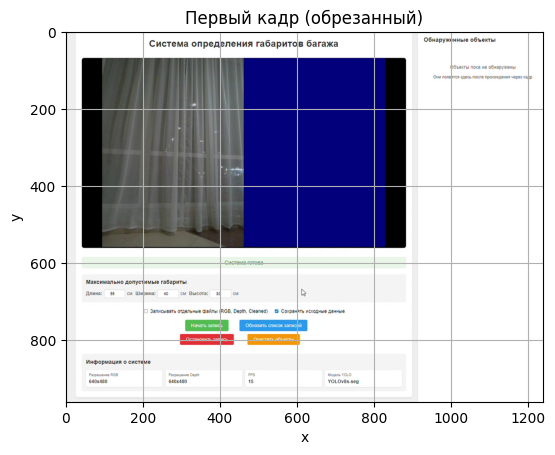

In [23]:
from moviepy import VideoFileClip

import matplotlib.pyplot as plt

def trim_and_crop_video(input_path, output_path, start_time, end_time, x1=0, y1=0, x2=0, y2=0):
    """
    Обрезает видео по времени и вырезает указанный прямоугольник (crop).
    Также отображает первый кадр с координатными осями.
    """
    with VideoFileClip(input_path) as video:
        
        # Безопасная длительность
        duration = video.duration
        if end_time > duration:
            end_time = duration - 0.1  # чтобы не упереться в повреждённый кадр

        # Обрезка по времени
        trimmed = video.subclipped(start_time, end_time)
        if (x1**2+x2**2+y1**2+y2**2) > 0:
            cropped = trimmed.cropped(x1=x1, y1=y1, x2=x2, y2=y2)

        # Сохраняем результат
        cropped.write_videofile(output_path, codec='libx264', audio_codec='aac')

        # Показываем первый кадр с осями
        frame = cropped.get_frame(0)  # кадр на 0-й секунде
        plt.imshow(frame)
        plt.title("Первый кадр (обрезанный)")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.show()

        # Обрезка по координатам
        


trim_and_crop_video("school_data/input.mp4", "output.mp4", start_time=28, end_time=45, x1=340, y1=120, x2=1580, y2=1280)

In [27]:
def convert_to_gif(input_path, output_gif_path, start_time=None, end_time=None, resize_factor=1.0, fps=10):
    """
    Конвертирует видео в GIF.
    
    :param input_path: путь к видеофайлу (.mp4)
    :param output_gif_path: путь к итоговому gif-файлу
    :param start_time: (опц.) начальное время в секундах
    :param end_time: (опц.) конечное время в секундах
    :param resize_factor: коэффициент изменения размера (1.0 = без изменений)
    :param fps: кадров в секунду для GIF
    """
    with VideoFileClip(input_path) as video:
        if start_time is not None or end_time is not None:
            video = video.subclipped(start_time or 0, end_time or video.duration)
        
        if resize_factor != 1.0:
            video = video.resized(resize_factor)

        video.write_gif(output_gif_path, fps=fps)
        
convert_to_gif(
    input_path="output.mp4",
    output_gif_path="example.gif",
    start_time=0,
    end_time=None,
    resize_factor=0.7,  # уменьшить размер на 50%
    fps=10
)

MoviePy - Building file example.gif with imageio.


In [10]:
import cv2
import numpy as np

def merge_videos(video1_path, video2_path, output_path, skip_frames=0):
    """
    Объединяет два MP4 видео последовательно (одно за другим)
    
    Args:
        video1_path: путь к первому видео
        video2_path: путь ко второму видео
        output_path: путь для сохранения результата
        skip_frames: количество кадров для пропуска у второго видео
    """
    
    # Открываем видео
    cap1 = cv2.VideoCapture(video1_path)
    cap2 = cv2.VideoCapture(video2_path)
    
    # Получаем параметры первого видео (оно задает размер)
    fps = int(cap1.get(cv2.CAP_PROP_FPS))
    width1 = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Размеры второго видео
    width2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
    height2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Видео 1: {width1}x{height1}, FPS: {fps}")
    print(f"Видео 2: {width2}x{height2}")
    
    # Создаем видео писатель
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width1, height1))
    
    frame_count = 0
    
    # Записываем все кадры первого видео
    print("Записываем первое видео...")
    while True:
        ret, frame = cap1.read()
        if not ret:
            break
        
        out.write(frame)
        frame_count += 1
        
        if frame_count % 30 == 0:
            print(f"Первое видео - кадров: {frame_count}")
    
    # Пропускаем кадры у второго видео
    print(f"Пропускаем {skip_frames} кадров второго видео...")
    for _ in range(skip_frames):
        ret, _ = cap2.read()
        if not ret:
            break
    
    # Записываем кадры второго видео
    print("Записываем второе видео...")
    while True:
        ret, frame = cap2.read()
        if not ret:
            break
        
        # Изменяем размер кадра под первое видео
        frame = cv2.resize(frame, (width1, height1))
        
        out.write(frame)
        frame_count += 1
        
        if frame_count % 30 == 0:
            print(f"Общий счетчик кадров: {frame_count}")
    
    # Освобождаем ресурсы
    cap1.release()
    cap2.release()
    out.release()
    
    print(f"Готово! Сохранено {frame_count} кадров в {output_path}")

# Пример использования
video1_path = "school_data/1.mp4"
video2_path = "school_data/2.mp4"
output_path = "merged_video.mp4"
skip_frames = 25  # пропустить первые 10 кадров у второго видео

merge_videos(video1_path, video2_path, output_path, skip_frames)

Видео 1: 720x1280, FPS: 60
Видео 2: 644x1428
Записываем первое видео...
Первое видео - кадров: 30
Первое видео - кадров: 60
Первое видео - кадров: 90
Первое видео - кадров: 120
Первое видео - кадров: 150
Первое видео - кадров: 180
Первое видео - кадров: 210
Первое видео - кадров: 240
Первое видео - кадров: 270
Первое видео - кадров: 300
Первое видео - кадров: 330
Пропускаем 25 кадров второго видео...
Записываем второе видео...
Общий счетчик кадров: 360
Общий счетчик кадров: 390
Общий счетчик кадров: 420
Готово! Сохранено 439 кадров в merged_video.mp4
